# 1. Imports

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import gzip
from urllib import request
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Dataset Loader: load_mnist
filename = [
    ["training_images", "train-images-idx3-ubyte.gz"],
    ["test_images", "t10k-images-idx3-ubyte.gz"],
    ["training_labels", "train-labels-idx1-ubyte.gz"],
    ["test_labels", "t10k-labels-idx1-ubyte.gz"]
]

def download_mnist():
    base_url = "https://peterbloem.nl/files/mnist/"
    for name in filename:
        print("Downloading " + name[1] + "...")
        request.urlretrieve(base_url + name[1], name[1])
    print("Download complete.")

def save_mnist():
    mnist = {}
    for name in filename[:2]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28 * 28)
    for name in filename[-2:]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=8)
    with open("mnist.pkl", 'wb') as f:
        pickle.dump(mnist, f)
    print("Save complete.")

def init():
    download_mnist()
    save_mnist()

def load():
    with open("mnist.pkl", 'rb') as f:
        mnist = pickle.load(f)
    return mnist["training_images"], mnist["training_labels"], mnist["test_images"], mnist["test_labels"]

def load_mnist(final=False, flatten=True):
    if not os.path.isfile('mnist.pkl'):
        init()
    xtrain, ytrain, xtest, ytest = load()
    xtl, xsl = xtrain.shape[0], xtest.shape[0]
    if flatten:
        xtrain = xtrain.reshape(xtl, -1)
        xtest = xtest.reshape(xsl, -1)
    if not final:
        return (xtrain[:-5000], ytrain[:-5000]), (xtrain[-5000:], ytrain[-5000:]), 10
    return (xtrain, ytrain), (xtest, ytest), 10


In [60]:
# data normalization
(xtrain, ytrain), (xval, yval), num_classes = load_mnist()
xtrain = xtrain / 255.0
xval = xval / 255.0
# Forward and Backward Passes
def forwardpass(X, W, V, b_in, b_hidden):
    k = np.dot(X, W) + b_in
    h = 1 / (1 + np.exp(-k))
    o = np.dot(h, V) + b_hidden
    exp_values = np.exp(o - np.max(o, axis=1, keepdims=True))
    y_pred = exp_values / np.sum(exp_values, axis=1, keepdims=True)
    return y_pred, h

def backward_pass(y_pred, y_true, h, X, W, V):
    delta = y_pred - y_true
    v_prime = np.dot(h.T, delta) / X.shape[0]
    b_prime_hidden = np.sum(delta, axis=0, keepdims=True) / X.shape[0]
    h_prime = np.dot(delta, V.T) * h * (1 - h)
    w_prime = np.dot(X.T, h_prime) / X.shape[0]
    b_prime_input = np.sum(h_prime, axis=0, keepdims=True) / X.shape[0]
    return v_prime, w_prime, b_prime_hidden, b_prime_input



# 2. Train with Multiple Initializations

Random Initialization Run 1
Random Initialization Run 2
Random Initialization Run 3


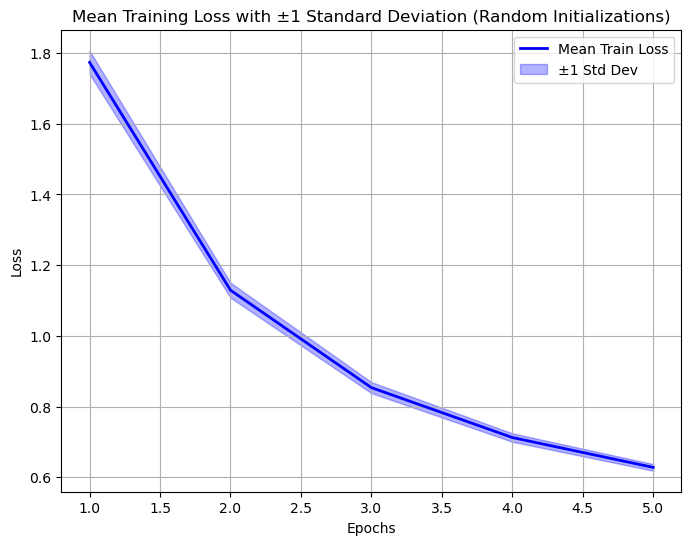

In [64]:
def train_multiple_initializations(xtrain, ytrain, xval, yval, num_classes, num_runs=3, epochs=5, batch_size=32, learning_rate=0.003):
    num_inputs = xtrain.shape[1]
    num_hidden_units = 300
    num_outputs = num_classes
    all_losses = []
    for run in range(num_runs):
        print(f"Random Initialization Run {run + 1}")
        W = np.random.normal(0, 0.1, (num_inputs, num_hidden_units))
        V = np.random.normal(0, 0.1, (num_hidden_units, num_outputs))
        b_in = np.zeros((1, num_hidden_units))
        b_hidden = np.zeros((1, num_outputs))
        train_losses = []
        for epoch in range(epochs):
            epoch_loss = 0
            for i in range(0, xtrain.shape[0], batch_size):
                X_batch = xtrain[i:i + batch_size]
                y_batch = np.eye(num_classes)[ytrain[i:i + batch_size]]
                y_pred, h = forwardpass(X_batch, W, V, b_in, b_hidden)
                batch_loss = -np.sum(y_batch * np.log(y_pred + 1e-8)) / batch_size
                epoch_loss += batch_loss
                v_prime, w_prime, b_prime_hidden, b_prime_input = backward_pass(y_pred, y_batch, h, X_batch, W, V)
                W -= learning_rate * w_prime
                V -= learning_rate * v_prime
                b_in -= learning_rate * b_prime_input
                b_hidden -= learning_rate * b_prime_hidden
            train_losses.append(epoch_loss / (xtrain.shape[0] // batch_size))
        all_losses.append(train_losses)
    all_losses = np.array(all_losses)
    mean_loss = np.mean(all_losses, axis=0)
    std_loss = np.std(all_losses, axis=0)
    epoch_range = np.arange(1, len(mean_loss) + 1)
    plt.figure(figsize=(8, 6))
    plt.plot(epoch_range, mean_loss, label="Mean Train Loss", color='blue', lw=2)
    plt.fill_between(epoch_range, mean_loss - std_loss, mean_loss + std_loss, color='blue', alpha=0.3, label="±1 Std Dev")
    plt.title("Mean Training Loss with ±1 Standard Deviation (Random Initializations)")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.savefig("mean_train_loss_std_dev.png")
    plt.show()

# Run training with multiple initializations
train_multiple_initializations(xtrain, ytrain, xval, yval, num_classes)

# 3. Train with Different Learning Rates

Training with learning rate: 0.001
Training with learning rate: 0.003
Training with learning rate: 0.01
Training with learning rate: 0.03


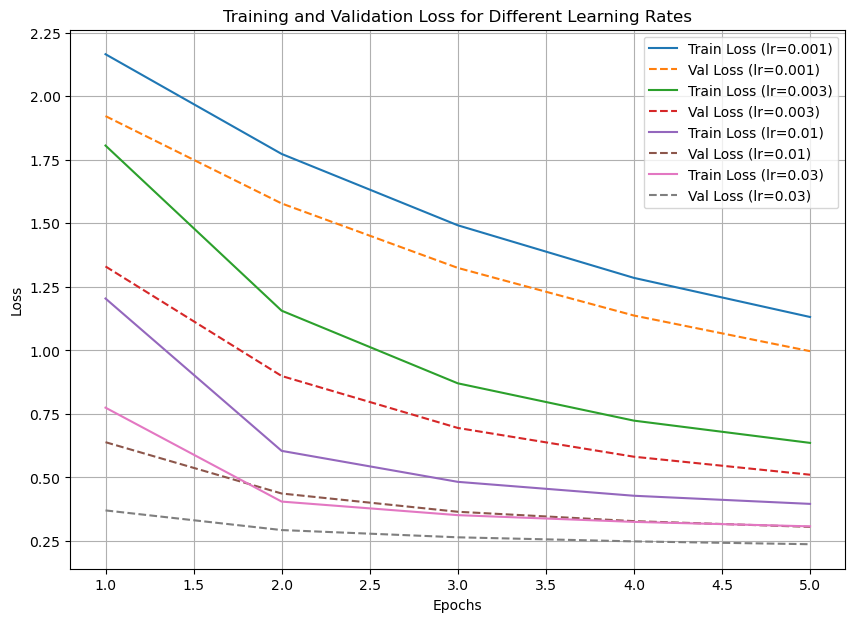

In [66]:
def train_different_learning_rates(xtrain, ytrain, xval, yval, num_classes, epochs=5, batch_size=32):
    learning_rates = [0.001, 0.003, 0.01, 0.03]
    plt.figure(figsize=(10, 7))
    for lr in learning_rates:
        print(f"Training with learning rate: {lr}")
        train_losses = []
        val_losses = []
        num_inputs = xtrain.shape[1]
        num_hidden_units = 300
        num_outputs = num_classes
        W = np.random.normal(0, 0.1, (num_inputs, num_hidden_units))
        V = np.random.normal(0, 0.1, (num_hidden_units, num_outputs))
        b_in = np.zeros((1, num_hidden_units))
        b_hidden = np.zeros((1, num_outputs))
        for epoch in range(epochs):
            epoch_loss = 0
            for i in range(0, xtrain.shape[0], batch_size):
                X_batch = xtrain[i:i + batch_size]
                y_batch = np.eye(num_classes)[ytrain[i:i + batch_size]]
                y_pred, h = forwardpass(X_batch, W, V, b_in, b_hidden)
                batch_loss = -np.sum(y_batch * np.log(y_pred + 1e-8)) / batch_size
                epoch_loss += batch_loss
                v_prime, w_prime, b_prime_hidden, b_prime_input = backward_pass(y_pred, y_batch, h, X_batch, W, V)
                W -= lr * w_prime
                V -= lr * v_prime
                b_in -= lr * b_prime_input
                b_hidden -= lr * b_prime_hidden
            train_losses.append(epoch_loss / (xtrain.shape[0] // batch_size))
            y_val_pred, _ = forwardpass(xval, W, V, b_in, b_hidden)
            val_loss = -np.sum(np.eye(num_classes)[yval] * np.log(y_val_pred + 1e-8)) / xval.shape[0]
            val_losses.append(val_loss)
        plt.plot(range(1, epochs + 1), train_losses, label=f"Train Loss (lr={lr})")
        plt.plot(range(1, epochs + 1), val_losses, linestyle='--', label=f"Val Loss (lr={lr})")
    plt.title("Training and Validation Loss for Different Learning Rates")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.savefig("learning_rate_comparison.png")
    plt.show()

# Run training with learning rate analysis
train_different_learning_rates(xtrain, ytrain, xval, yval, num_classes)

# 4. Final Training

Epoch 1/5, Training Loss: 0.7764, Validation Loss: 0.3661
Epoch 2/5, Training Loss: 0.4045, Validation Loss: 0.2909
Epoch 3/5, Training Loss: 0.3511, Validation Loss: 0.2624
Epoch 4/5, Training Loss: 0.3245, Validation Loss: 0.2499
Epoch 5/5, Training Loss: 0.3070, Validation Loss: 0.2363

Final Test Loss: 0.2363
Final Test Accuracy: 93.34%


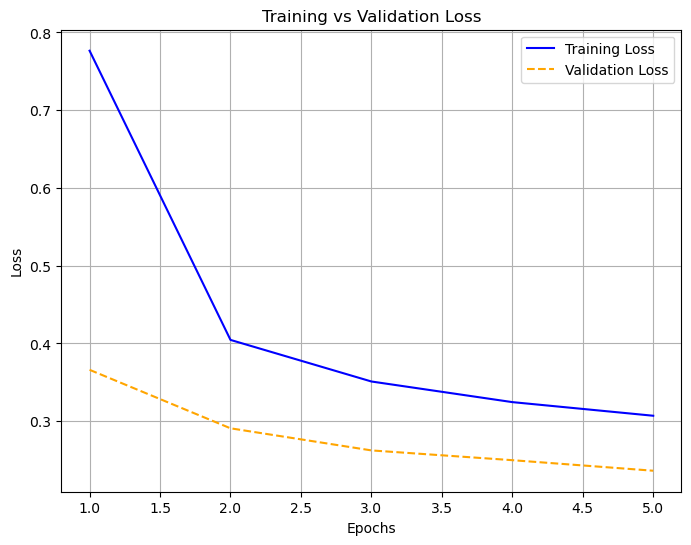

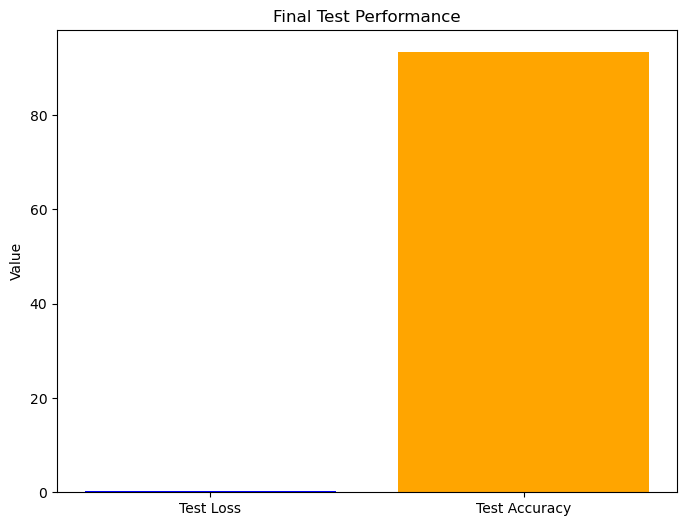

<Figure size 800x600 with 0 Axes>

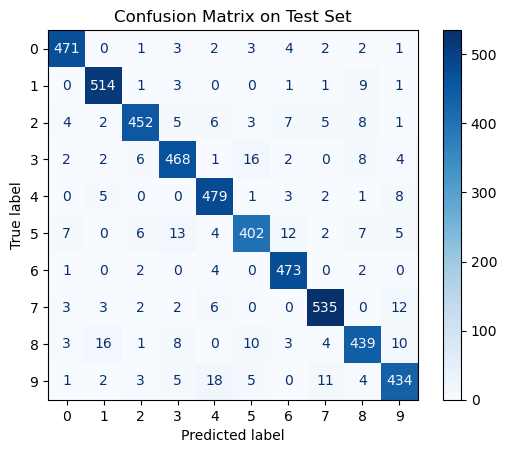

In [70]:
learning_rate = 0.03
epochs = 5
batch_size = 32

num_inputs = x_train_full.shape[1]
num_hidden_units = 300
num_outputs = num_classes

np.random.seed(0)
W = np.random.normal(0, 0.1, (num_inputs, num_hidden_units))
b_in = np.zeros((1, num_hidden_units))
V = np.random.normal(0, 0.1, (num_hidden_units, num_outputs))
b_hidden = np.zeros((1, num_outputs))

def forwardpass(X, W, V, b_in, b_hidden):
    k = np.dot(X, W) + b_in
    h = 1 / (1 + np.exp(-k))
    o = np.dot(h, V) + b_hidden
    exp_values = np.exp(o - np.max(o, axis=1, keepdims=True))
    y_pred = exp_values / np.sum(exp_values, axis=1, keepdims=True)
    return y_pred, h

def backward_pass(y_pred, y_true, h, X, W, V):
    delta = y_pred - y_true
    v_prime = np.dot(h.T, delta) / X.shape[0]
    b_prime_hidden = np.sum(delta, axis=0, keepdims=True) / X.shape[0]
    h_prime = np.dot(delta, V.T) * h * (1 - h)
    w_prime = np.dot(X.T, h_prime) / X.shape[0]
    b_prime_input = np.sum(h_prime, axis=0, keepdims=True) / X.shape[0]
    return v_prime, w_prime, b_prime_hidden, b_prime_input

y_train_one_hot = np.eye(num_classes)[y_train_full]
y_test_one_hot = np.eye(num_classes)[y_test]

train_losses = []
val_losses = []

for epoch in range(epochs):
    epoch_loss = 0
    indices = np.random.permutation(x_train_full.shape[0])
    x_train_shuffled = x_train_full[indices]
    y_train_shuffled = y_train_one_hot[indices]

    for start in range(0, x_train_full.shape[0], batch_size):
        end = start + batch_size
        X_batch = x_train_shuffled[start:end]
        y_batch = y_train_shuffled[start:end]

        y_pred, h = forwardpass(X_batch, W, V, b_in, b_hidden)
        batch_loss = -np.sum(y_batch * np.log(y_pred + 1e-8)) / batch_size
        epoch_loss += batch_loss

        v_prime, w_prime, b_prime_hidden, b_prime_input = backward_pass(y_pred, y_batch, h, X_batch, W, V)
        W -= learning_rate * w_prime
        V -= learning_rate * v_prime
        b_in -= learning_rate * b_prime_input
        b_hidden -= learning_rate * b_prime_hidden

    avg_epoch_loss = epoch_loss / (x_train_full.shape[0] // batch_size)
    train_losses.append(avg_epoch_loss)

    y_pred_val, _ = forwardpass(x_test, W, V, b_in, b_hidden)
    val_loss = -np.sum(y_test_one_hot * np.log(y_pred_val + 1e-8)) / y_test.shape[0]
    val_losses.append(val_loss)

    print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {avg_epoch_loss:.4f}, Validation Loss: {val_loss:.4f}")

# Final Evaluation
y_pred_test, _ = forwardpass(x_test, W, V, b_in, b_hidden)
test_loss = -np.sum(y_test_one_hot * np.log(y_pred_test + 1e-8)) / y_test.shape[0]
y_pred_classes = np.argmax(y_pred_test, axis=1)
test_accuracy = accuracy_score(y_test, y_pred_classes)

print(f"\nFinal Test Loss: {test_loss:.4f}")
print(f"Final Test Accuracy: {test_accuracy * 100:.2f}%")

plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs + 1), train_losses, label="Training Loss", color='blue')
plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss", color='orange', linestyle="--")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid()
plt.savefig("final_training_vs_validation_loss.png")
plt.show()

plt.figure(figsize=(8, 6))
plt.bar(["Test Loss", "Test Accuracy"], [test_loss, test_accuracy * 100], color=["blue", "orange"])
plt.title("Final Test Performance")
plt.ylabel("Value")
plt.savefig("final_test_performance.png")
plt.show()

conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=range(num_classes))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix on Test Set")
plt.savefig("confusion_matrix_test.png")
plt.show()
